<a href="https://colab.research.google.com/github/JoaoCarabetta/isometric/blob/master/isometric.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Make sure that the section is running on Python 3
Runtime >> Change Runtime Type >> Runtime Type = Python3

# Setup == Run this every time you use!

In [0]:
# Instalação de Pacotes na máquina
!pip3 install osmnx
!pip3 install networkx


# Instalação pacote Spatial Index (um pouco trabalhosa, requer linhas a seguir)
!apt-get install -qq curl g++ make
!curl -L http://download.osgeo.org/libspatialindex/spatialindex-src-1.8.5.tar.gz | tar xz
import os
os.chdir('spatialindex-src-1.8.5')
!./configure
!make
!make install
!pip3 install rtree
!ldconfig

# Importação de Pacotes
import networkx as nx # Pacote de redes do Python
from google.colab import files # Pacote Google Colab (só necessário no ambiente virtual)
import osmnx as ox # Pacote OSM Network X
import geopandas as gpd # Pacote Pandas Georreferenciado
import matplotlib.pyplot as plt # Pacote MatplotLib
from shapely.geometry import Point, LineString, Polygon, mapping # Pacote Shapely (apenas partes do pacote)
from shapely.ops import cascaded_union
from descartes import PolygonPatch #  Pacote Descartes (apenas parte do pacote)
ox.config(log_console=True, use_cache=True)

import ast # Pacote para transformar string em lista
from copy import deepcopy # duplicar memória do Pyhton
from collections import defaultdict # criar dicionário com chave pronta
import fiona # possibilitar exportação
from tqdm import tqdm # Pacote para visualizar downloads
import pandas as pd 
import geopandas as gdp

# Pacote Python para plotar gráfico
from pylab import rcParams
rcParams['figure.figsize'] = 16, 25 # Tamanho da figura pode ser customizado

    100% |████████████████████████████████| 71kB 2.8MB/s 
    100% |████████████████████████████████| 13.9MB 2.5MB/s 
    100% |████████████████████████████████| 12.9MB 974kB/s 
    100% |████████████████████████████████| 1.5MB 12.2MB/s 
    100% |████████████████████████████████| 8.9MB 4.0MB/s 
    100% |████████████████████████████████| 61kB 22.8MB/s 
    100% |████████████████████████████████| 901kB 14.6MB/s 
    100% |████████████████████████████████| 952kB 18.1MB/s 
    100% |████████████████████████████████| 4.4MB 7.9MB/s 
    100% |████████████████████████████████| 17.9MB 803kB/s 
  Running setup.py bdist_wheel for pyproj ... - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ 

# Code == Run this too!

In [0]:
# Organização do código:
# Main = função principal que chama outras funções

def string_to_list(string):
    """
    Transformação de strings em uma lista
    """
    return ast.literal_eval('[' + string + ']')

def strings_to_list(*args):
    """
    Empacotamento de strings em uma lista
    """
    return list(map(string_to_list, args))

def download_graph(coordinates, distances):
    """
    Criação do grafo de ruas do OSM a partir das coordenadas solicitadas
    """
    max_distance = max(distances)
    
    G = False
    for coordinate in tqdm(coordinates, desc='Downloading'):

        if G: # "soma" (merge) com grafo já existente (deepcopy utilizado para não perder grafo entre iterações)
            G = nx.compose(deepcopy(G), ox.graph_from_point(coordinate, 
                                                  distance=max_distance,
                                                  network_type='walk'))
        else: # inicializa grafo a partir de todos pontos
            G = ox.graph_from_point(coordinate, distance=max_distance, 
                                    network_type='walk')            
    
    return G


def make_iso_polys(G, coordinate, distances, center_nodes,
                   edge_buff=25, node_buff=0, infill=True):
    """
    Criação do grafo de isótopas
    
    {trip_length: }
    """
    isochrone_polys = {}
    for trip_length in tqdm(sorted(distances, reverse=True), # Ordenar para ter visualização das diferentes distâncias
                            desc='Calculating Isometric'):
        isochrone_polys[trip_length] = {}
        polygons = []
        for center_node, coor in zip(center_nodes, coordinates):

            subgraph = nx.ego_graph(G, center_node, radius=trip_length, 
                                    distance='length')
            

            node_points = [Point((data['x'], data['y'])) 
                           for node, data in subgraph.nodes(data=True)]
            
            nodes_gdf = gpd.GeoDataFrame({'id': subgraph.nodes()},
                                         geometry=node_points)
            nodes_gdf = nodes_gdf.set_index('id')

            edge_lines = []
            for n_fr, n_to in subgraph.edges():
                f = nodes_gdf.loc[n_fr].geometry
                t = nodes_gdf.loc[n_to].geometry
                edge_lines.append(LineString([f,t]))

            n = nodes_gdf.buffer(node_buff).geometry
            e = gpd.GeoSeries(edge_lines).buffer(edge_buff).geometry
            all_gs = list(n) + list(e)
            new_iso = gpd.GeoSeries(all_gs).unary_union # junção de pontos e edges, mas com buracos nas quadras

            # try to fill in surrounded areas so shapes will appear solid and blocks without white space inside them
            if infill:
                new_iso = Polygon(new_iso.exterior)
            polygons.append(new_iso)
            
        isochrone_polys[trip_length] = cascaded_union(polygons) # junta todos os poligonos no entorno das coordenadas 

    return isochrone_polys


def plot(G, isochrone_polys, center_nodes, distances):
    
    nc = ['blue' if node in center_nodes else 'none' for node in G.nodes()]
    ns = [20 if node in center_nodes else 0 for node in G.nodes()]
    
    iso_colors = ox.get_colors(n=len(distances), cmap='Reds', 
                               start=0.3, return_hex=True)
    
    # plot the network then add isochrones as colored descartes polygon patches
    fig, ax = ox.plot_graph(G, fig_height=8, show=False, close=False, 
                             edge_color='k', edge_alpha=0.2, node_color=nc,
                           node_size=ns)
    
    for dist, poly in tqdm(isochrone_polys.items(), desc='Plotting'):
        patch = PolygonPatch(poly, fc='red', ec='none', alpha=0.6, zorder=-1)
        ax.add_patch(patch)
    
    plt.show()

def export(polygons):
    
    from google.colab import drive
    drive.mount('/content/gdrive')
    
    from functools import partial
    import pyproj
    from shapely.ops import transform

#     project = partial(
#         pyproj.transform,
#         pyproj.Proj(init='epsg:27700'), # source coordinate system
#         pyproj.Proj(init='epsg:4326')) # destination coordinate system

#     g2 = transform(project, polygons[500])  # apply projection
#     polygons = {key: transform(project, p) for key, p in polygons.items()}

    a = pd.DataFrame.from_dict(polygons, orient='index').T
    a = pd.melt(a, value_vars=a.columns)
    a.columns = ['distance', 'polygon']
    a = gpd.GeoDataFrame(a, geometry='polygon')
    a.to_csv('/content/gdrive/My Drive/polygons.csv')
    
    print('Polygons saved in your drive at My Drive/polygons.csv')
    
        
# Main = função principal que recebe coordenadas e distância e chama outras funções
def main(coordinates, distances, projection):
    
    # Convert string to list
    coordinates, distances = strings_to_list(coordinates, distances)
    
    # Download Graph     
    G = download_graph(coordinates, distances)
    
    # Get central nodes
    center_nodes = [ox.get_nearest_node(G, coor) for coor in coordinates]
    
    # Project Graph
    G = ox.project_graph(G)
    
    # Get polygons
    isochrone_polys = make_iso_polys(G, coordinates, distances, center_nodes)
    
    # Plot
    plot(G, isochrone_polys, center_nodes, distances)
    

    # Export
    export(isochrone_polys)
    
    
    return isochrone_polys
    

# How to input
coordinates: (-22.94,-43.18), (-22.96,-43.21) :: (lat, long), (lat, long) as a string

distances: 200, 500, 1000 :: distance as string

If you want the isochrone, just convert the trip time and walking speed to distance. Then, copy the result to the isometric calculator.

In [0]:
#@title Time to Distance
trips_time_in_minutes = "5, 10, 15, 20" #@param {type:"string"}
walking_speed = 3 #@param {type:"number"}
speed_unit = "km/h" #@param ["km/h", "m/s"]

if speed_unit == 'km/h':
    walking_speed = walking_speed/3.6
    
list(map(lambda x: walking_speed * x * 60, string_to_list(trips_time_in_minutes)))

[249.99999999999997, 499.99999999999994, 749.9999999999999, 999.9999999999999]


Downloading: 100%|██████████| 261/261 [28:52<00:00, 10.14s/it]

Calculating Isometric: 100%|██████████| 2/2 [03:47<00:00, 140.24s/it]

Plotting: 100%|██████████| 2/2 [00:00<00:00, 43.37it/s]

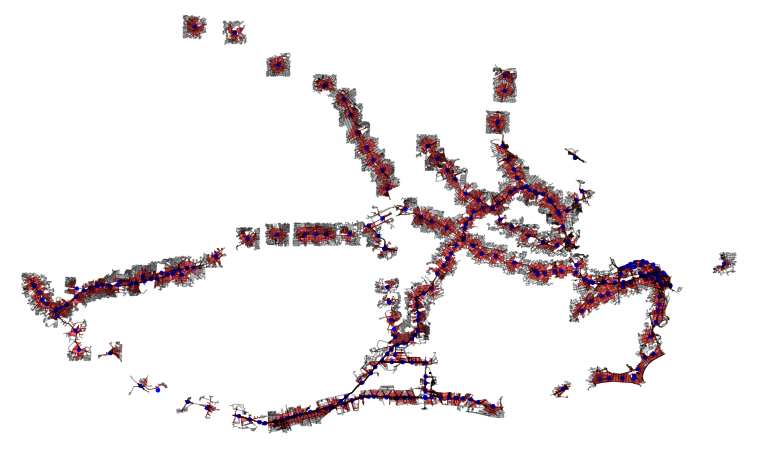

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive
Polygons saved in your drive at My Drive/polygons.csv


In [0]:
#@title Isometric Calculator
coordinates = "(-22.903536,-43.191477), (-22.902725,-43.171975), (-22.894346,-43.124362), (-22.924528,-43.23251), (-22.920547,-43.223686), (-22.918457,-43.217842), (-22.913506,-43.20628), (-22.909821,-43.200344), (-22.90473,-43.19099), (-22.903465,-43.185905), (-22.902794,-43.181553), (-22.907467,-43.178211), (-22.910719,-43.175777), (-22.920374,-43.176708), (-22.926342,-43.176636), (-22.931126,-43.177986), (-22.939533,-43.178749), (-22.950342,-43.184231), (-22.964893,-43.180893), (-22.967594,-43.187206), (-22.976412,-43.19381), (-22.983196,-43.196977), (-22.909573,-43.206135), (-22.909725,-43.220959), (-22.909815,-43.233948), (-22.897079,-43.244328), (-22.881548,-43.260098), (-22.879374,-43.271805), (-22.874599,-43.283554), (-22.867947,-43.297379), (-22.862469,-43.306816), (-22.854061,-43.313206), (-22.847649,-43.324108), (-22.84267,-43.334709), (-22.831636,-43.343216), (-22.824656,-43.349644), (-22.816275,-43.358524), (-22.806171,-43.365814), (-22.93185,-43.239625), (-23.006787,-43.310643), (-22.991825,-43.254815), (-22.98459,-43.224066), (-22.983777,-43.216929), (-22.983691,-43.205951), (-22.98222,-43.196354), (-22.910027,-43.212988), (-22.909837,-43.223006), (-22.90974,-43.231223), (-22.908279,-43.237204), (-22.902347,-43.244811), (-22.901588,-43.256393), (-22.901945,-43.26179), (-22.903188,-43.269992), (-22.903946,-43.275604), (-22.901796,-43.278056), (-22.895558,-43.294441), (-22.890491,-43.309605), (-22.888525,-43.32118), (-22.882752,-43.328048), (-22.877312,-43.336581), (-22.869378,-43.349833), (-22.864309,-43.362065), (-22.860974,-43.370659), (-22.854909,-43.383517), (-22.8626411,-43.4022372), (-22.867999,-43.413262), (-22.8748,-43.428626), (-22.875185,-43.44743), (-22.87526,-43.455949), (-22.875409,-43.464844), (-22.87585,-43.487189), (-22.879383,-43.511071), (-22.892849,-43.537155), (-22.902214,-43.560393), (-22.906134,-43.580898), (-22.909184,-43.595703), (-22.912919,-43.61472), (-22.91631,-43.632424), (-22.918914,-43.649462), (-22.915934,-43.684725), (-22.839387,-43.398157), (-22.825387,-43.402393), (-22.817465,-43.410029), (-22.808092,-43.41547), (-22.796183,-43.422704), (-22.782814,-43.428703), (-22.770941,-43.433974), (-22.760673,-43.450057), (-22.744716,-43.487814), (-22.720113,-43.523437), (-22.716148,-43.555925), (-22.896775,-43.244137), (-22.878338,-43.251485), (-22.866838,-43.255645), (-22.855774,-43.259654), (-22.84715,-43.266408), (-22.840298,-43.278551), (-22.836374,-43.285318), (-22.830165,-43.29322), (-22.823586,-43.296125), (-22.816272,-43.300766), (-22.80565,-43.305429), (-22.787245,-43.30949), (-22.751678,-43.304238), (-22.763055,-43.304022), (-23.000406,-43.366062), (-22.989018,-43.36578), (-22.948212,-43.372384), (-22.877582,-43.336122), (-22.838843,-43.295112), (-22.995608,-43.365846), (-22.940667,-43.372519), (-22.870011,-43.335513), (-22.837739,-43.289829), (-22.983973,-43.365647), (-22.936627,-43.371752), (-22.865877,-43.334421), (-22.839119,-43.283395), (-22.973265,-43.393504), (-22.97347,-43.365641), (-22.91565,-43.361229), (-22.935557,-43.371763), (-22.97697,-43.406464), (-22.861518,-43.330416), (-22.842588,-43.277239), (-22.973404,-43.376635), (-22.929403,-43.373375), (-22.856635,-43.328408), (-22.841918,-43.277419), (-22.973237,-43.384247), (-22.924147,-43.373839), (-22.853046,-43.32046), (-22.842376,-43.272463), (-22.967738,-43.390605), (-22.920134,-43.368259), (-22.852748,-43.312859), (-22.848618,-43.265465), (-22.959925,-43.388718), (-22.849765,-43.307977), (-22.85744,-43.258282), (-22.95861,-43.383351), (-22.904727,-43.357045), (-22.855142,-43.252481), (-22.955291,-43.377325), (-22.897718,-43.35224), (-22.963234,-43.393775), (-22.892802,-43.348628), (-22.83983,-43.240038), (-22.971483,-43.401417), (-22.888384,-43.345839), (-22.8853284,-43.3991826), (-22.927872,-43.39601), (-22.915562,-43.398098), (-22.886237,-43.400594), (-22.868137,-43.413154), (-22.862836,-43.402107), (-22.875943,-43.405253), (-22.940964,-43.394631), (-22.953019,-43.390469), (-22.966786,-43.397056), (-22.947872,-43.391661), (-23.000187,-43.429764), (-22.981805,-43.410174), (-23.003874,-43.434062), (-22.989572,-43.417621), (-22.93472,-43.665446), (-22.933433,-43.661969), (-22.931791,-43.65722), (-22.925411,-43.649911), (-22.920449,-43.643515), (-22.918259,-43.639077), (-22.916785,-43.632812), (-22.915627,-43.627974), (-22.841507,-43.298748), (-22.916242,-43.622514), (-22.915647,-43.616086), (-22.915113,-43.605839), (-22.914203,-43.601429), (-22.912832,-43.594564), (-22.911313,-43.589744), (-22.910837,-43.584167), (-22.90756,-43.575861), (-22.90695,-43.571721), (-22.882148,-43.342128), (-22.907631,-43.563975), (-22.901767,-43.55491), (-22.903561,-43.566244), (-22.950685,-43.650992), (-22.936558,-43.666932), (-22.940529,-43.665256), (-22.930899,-43.673467), (-22.927566,-43.677574), (-22.922283,-43.679643), (-22.917148,-43.68359), (-23.006145,-43.311048), (-22.952338,-43.374612), (-23.001412,-43.328694), (-23.000586,-43.335048), (-23.000298,-43.340264), (-23.000179,-43.34675), (-23.000077,-43.353061), (-22.99998,-43.360628), (-23.000137,-43.365743), (-23.000362,-43.378117), (-23.000448,-43.38275), (-23.000472,-43.388733), (-23.00027,-43.397301), (-22.99993,-43.407325), (-23.000051,-43.412122), (-23.000848,-43.417238), (-23.003202,-43.424818), (-23.005353,-43.431313), (-23.00803,-43.441738), (-23.009272,-43.446577), (-23.010867,-43.452742), (-23.012417,-43.458911), (-23.014524,-43.466945), (-23.015736,-43.471914), (-23.017042,-43.477019), (-23.018324,-43.481952), (-23.019655,-43.487222), (-23.021155,-43.495192), (-23.020699,-43.500346), (-23.018612,-43.508112), (-23.016101,-43.516867), (-23.009333,-43.542258), (-23.005372,-43.558418), (-22.999732,-43.582283), (-22.993865,-43.596724), (-22.968544,-43.621982), (-22.965697,-43.647133), (-23.008589,-43.440933), (-22.904404,-43.570612), (-23.003664,-43.323163), (-22.8471,-43.243876), (-22.814452,-43.24641), (-22.897262,-43.204318), (-22.898059,-43.204934), (-22.898061,-43.199465), (-22.895766,-43.191586), (-22.895851,-43.182113), (-22.896777,-43.201919), (-22.894103,-43.187362), (-22.901872,-43.173195), (-22.897562,-43.196836), (-22.905033,-43.178052), (-22.899016,-43.20748), (-22.905876,-43.187345), (-22.89544,-43.200422), (-22.912026,-43.167573), (-22.898527,-43.180081), (-22.905154,-43.177495), (-22.906491,-43.18287), (-22.903158,-43.208241), (-22.911105,-43.172005), (-22.893094,-43.190431), (-22.901592,-43.178885), (-22.907327,-43.17665), (-22.902731,-43.192695), (-22.894254,-43.197063), (-22.910567,-43.175386)" #@param {type:"string"}
distances = "500, 1000" #@param {type:"string"}
projection = "epsg:4326" #@param ["epsg:32625"]


polys = main(coordinates, distances, projection)

In [0]:
import pyproj

In [0]:
with open('/content/gdrive/My Drive/foo.txt', 'w') as f:
  f.write('Hello Google Drive!')
!cat /content/gdrive/My\ Drive/foo.txt

Hello Google Drive!

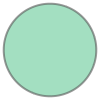

In [0]:
poly[500]

In [0]:
import pyproj as proj

# setup your projections
crs_wgs = proj.Proj(init='epsg:4326') # assuming you're using WGS84 geographic
crs_bng = proj.Proj(init='epsg:27700') # use a locally appropriate projected CRS

# then cast your geographic coordinate pair to the projected system
x, y = proj.transform(crs_wgs, crs_bng, input_lon, input_lat)

In [0]:
!pip3 install utm

In [0]:
import utm
utm.from_latlon(-8.0773,-34.91)


(289521.68996925885, 9106663.423057575, 25, 'L')